#Data Filtering

Importing necessary dependencies

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud

Loading the data from the drive into the pandas dataframe

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
df=pd.read_csv('gdrive/My Drive/final_reviews.csv')


Mounted at /content/gdrive


Downloading the stopwords

In [5]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Printing the stopwords

In [6]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Printing the size of the dataframe

In [7]:
df.shape

(5496, 2)

Printing the first five entries of the dataset

In [8]:
df.head()

,translated_content,sentiment
0,"Good for gambling, excellent performance, valu...",positive
1,"I am not a gamer by a long shot, but I wanted ...",positive
2,(a) Considering its current price and giving i...,positive
3,went from roots 5800x to this and I don't regr...,positive
4,It didn't happen when it was said it was not good,negative


Counting the missing values in the dataset

In [9]:
df.isnull().sum()

translated_content    0
sentiment             0
dtype: int64

Since there are no missing values so we can continue

Checking the distribution of the sentiment column

In [10]:
df['sentiment'].value_counts()

sentiment
positive    2567
neutral     1673
negative    1256
Name: count, dtype: int64

Visualizing for class Imbalance

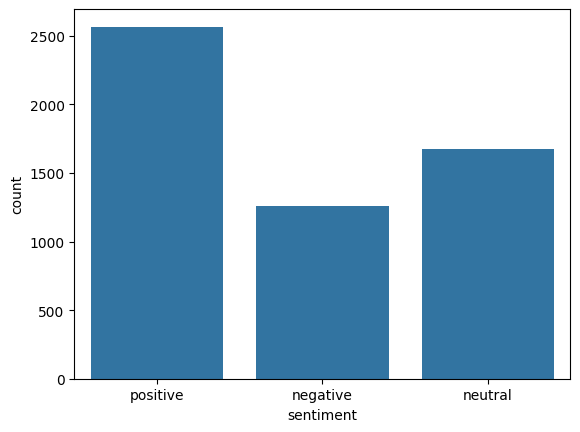

sentiment
positive    2567
neutral     1673
negative    1256
Name: count, dtype: int64


In [11]:
sns.countplot(x=df['sentiment'])
plt.show()
print(df['sentiment'].value_counts())

Up-sampling the minority classes to even out the distribution of classes and reduce bias in a model.

In [12]:
from sklearn.utils import resample
# Separate majority and minority classes
df_positive = df[df.sentiment == 'positive']
df_neutral = df[df.sentiment == 'neutral']
df_negative = df[df.sentiment == 'negative']

# Upsample minority classes
df_neutral_upsampled = resample(df_neutral,replace=True,n_samples=len(df_positive),random_state=123)
df_negative_upsampled = resample(df_negative,replace=True,n_samples=len(df_positive),random_state=123)

# Combine majority class with upsampled minority classes
df_upsampled = pd.concat([df_positive, df_neutral_upsampled, df_negative_upsampled])

# Display new class counts
df_upsampled['sentiment'].value_counts()

sentiment
positive    2567
neutral     2567
negative    2567
Name: count, dtype: int64

Printing the size of the upsampled dataframe

In [13]:
df_upsampled.shape

(7701, 2)

Visualizing after Sampling

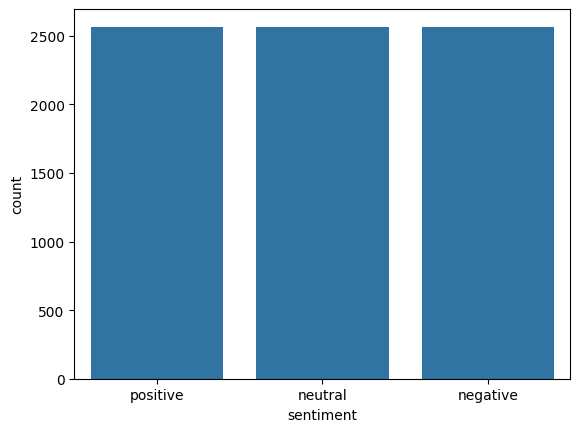

sentiment
positive    2567
neutral     2567
negative    2567
Name: count, dtype: int64


In [14]:
sns.countplot(x=df_upsampled['sentiment'])
plt.show()
print(df_upsampled['sentiment'].value_counts())

Stemming the data frame(Stemming is a process of reducing the word to its root word)

In [15]:
%%time
porter_stem=PorterStemmer()
def stemming(content):
  stemmed_reviews=re.sub('[^a-zA-Z]',' ',content)  #Removing all unnecessary symbols
  stemmed_reviews=stemmed_reviews.lower()          #Converting to lower case
  stemmed_reviews=stemmed_reviews.split()          #Splitting each word and storing it in a list
  stemmed_reviews=[porter_stem.stem(word) for word in stemmed_reviews if not word in stopwords.words('english')]  #Stemming all the words that are not a part of stopwords
  stemmed_reviews=' '.join(stemmed_reviews)
  return stemmed_reviews
#Making a new column as stemmed_reviews that holds the stemmed reviews
df_upsampled['stemmed_reviews']=df_upsampled['translated_content'].apply(stemming)


CPU times: user 28.8 s, sys: 3.71 s, total: 32.5 s
Wall time: 34.1 s


Printing the first five rows of the stemmed data frame

In [16]:
df_upsampled.head()

,translated_content,sentiment,stemmed_reviews
0,"Good for gambling, excellent performance, valu...",positive,good gambl excel perform valu money good stream
1,"I am not a gamer by a long shot, but I wanted ...",positive,gamer long shot want power intel base cpu maxi...
2,(a) Considering its current price and giving i...,positive,consid current price give rang game game slote...
3,went from roots 5800x to this and I don't regr...,positive,went root x regret especi ddr ram higher speed...
6,I just wanted to upgrade my PC so I could prop...,positive,want upgrad pc could properli load window perf...


#Exploratory Data Analysis

Distribution of Number of Words in Positive, Neutral, and Negative Reviews

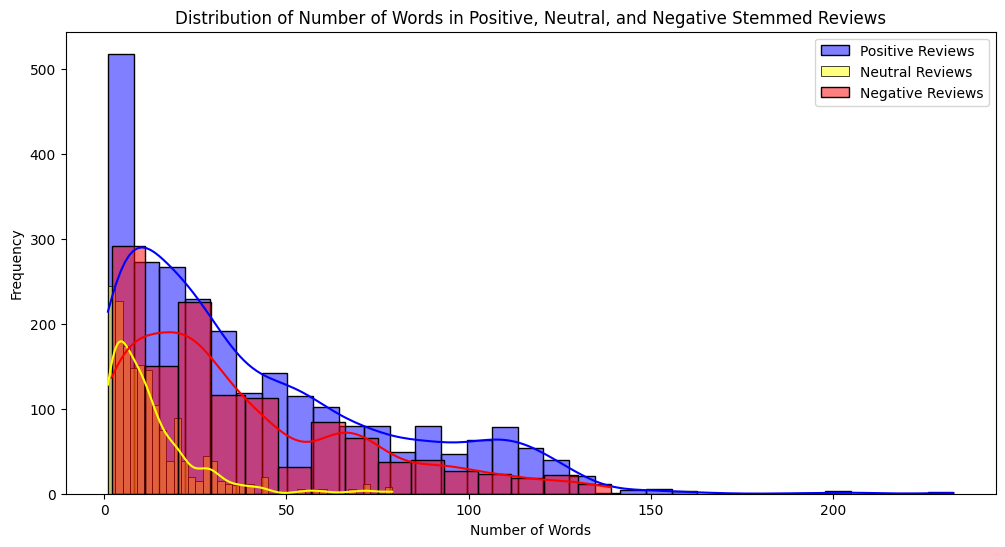

In [17]:
# Calculate the number of words in each stemmed review
df['word_count'] = df['translated_content'].apply(lambda x: len(str(x).split()))

# Filter positive, neutral, and negative reviews
df_positive = df[df.sentiment == 'positive']
df_neutral = df[df.sentiment == 'neutral']
df_negative = df[df.sentiment == 'negative']

# Plot the distribution of word counts for positive, neutral, and negative stemmed reviews
plt.figure(figsize=(12, 6))
sns.histplot(df_positive['word_count'], kde=True, color='blue', label='Positive Reviews')
sns.histplot(df_neutral['word_count'], kde=True, color='yellow', label='Neutral Reviews')
sns.histplot(df_negative['word_count'], kde=True, color='red', label='Negative Reviews')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Words in Positive, Neutral, and Negative Stemmed Reviews')
plt.legend()
plt.show()

2:Top 20 most frequent words in positive,negative and neutral reviews

<ipython-input-18-3285231cd5dd>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Word', y='Frequency', data=common_words_positive, palette='Blues_d')


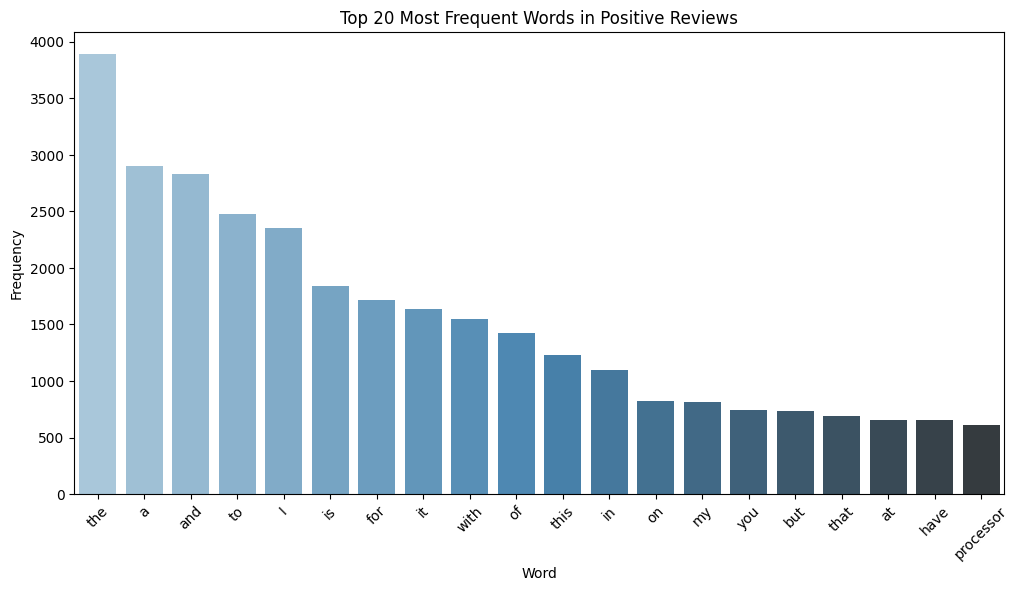

<ipython-input-18-3285231cd5dd>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Word', y='Frequency', data=common_words_neutral, palette='Greens_d')


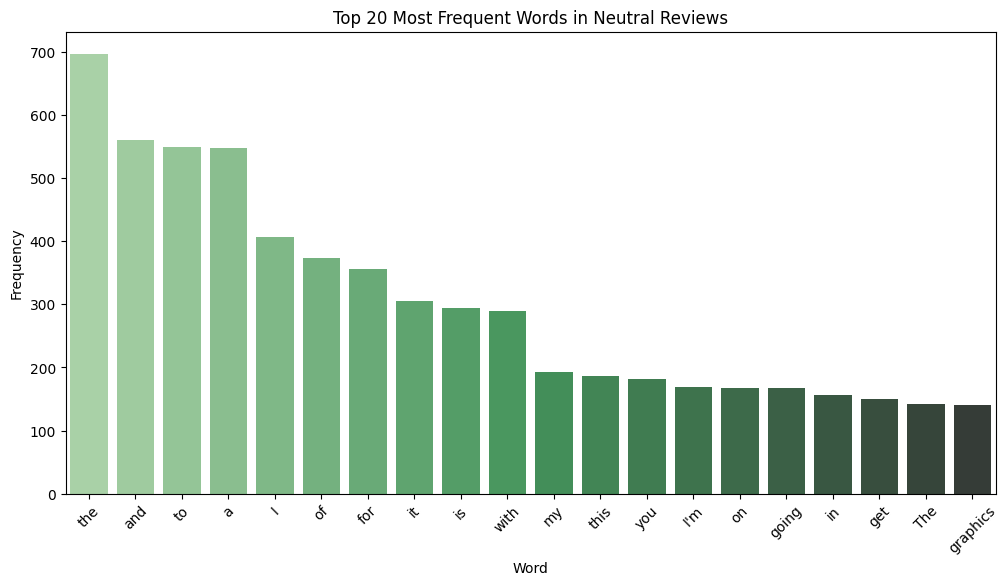

<ipython-input-18-3285231cd5dd>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Word', y='Frequency', data=common_words_negative, palette='Reds_d')


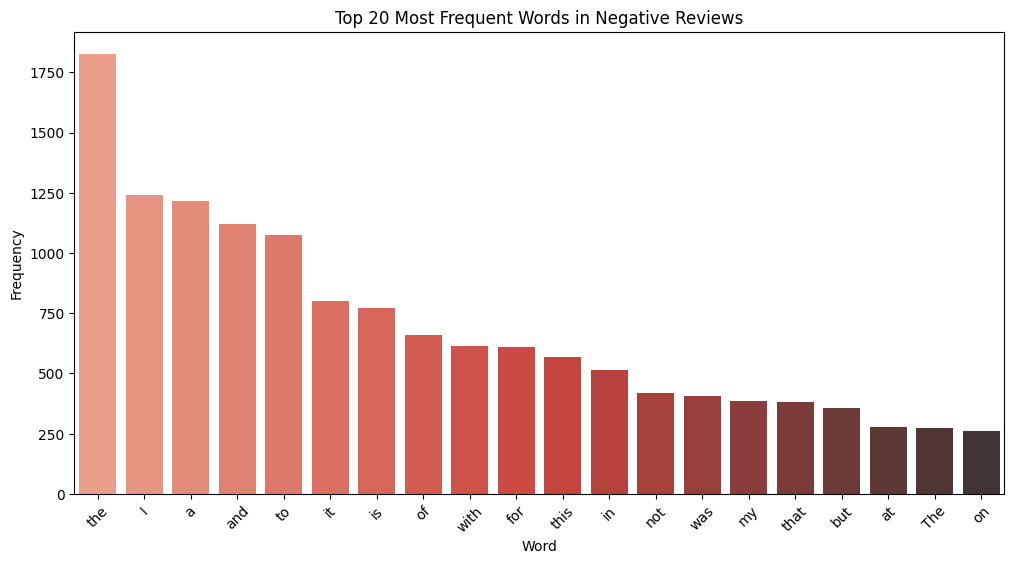

In [18]:
from collections import Counter

# Function to get the most frequent words
def get_most_frequent_words(text_series, num_words=20):
    all_words = ' '.join(text_series).split()
    word_freq = Counter(all_words)
    common_words = word_freq.most_common(num_words)
    return pd.DataFrame(common_words, columns=['Word', 'Frequency'])

# Filter reviews by sentiment
df_positive = df[df.sentiment == 'positive']
df_neutral = df[df.sentiment == 'neutral']
df_negative = df[df.sentiment == 'negative']

# Get the most frequent words for each sentiment
common_words_positive = get_most_frequent_words(df_positive['translated_content'])
common_words_neutral = get_most_frequent_words(df_neutral['translated_content'])
common_words_negative = get_most_frequent_words(df_negative['translated_content'])

# Plot the most frequent words for positive reviews
plt.figure(figsize=(12, 6))
sns.barplot(x='Word', y='Frequency', data=common_words_positive, palette='Blues_d')
plt.title('Top 20 Most Frequent Words in Positive Reviews')
plt.xticks(rotation=45)
plt.show()

# Plot the most frequent words for neutral reviews
plt.figure(figsize=(12, 6))
sns.barplot(x='Word', y='Frequency', data=common_words_neutral, palette='Greens_d')
plt.title('Top 20 Most Frequent Words in Neutral Reviews')
plt.xticks(rotation=45)
plt.show()

# Plot the most frequent words for negative reviews
plt.figure(figsize=(12, 6))
sns.barplot(x='Word', y='Frequency', data=common_words_negative, palette='Reds_d')
plt.title('Top 20 Most Frequent Words in Negative Reviews')
plt.xticks(rotation=45)
plt.show()

3:Visualization of Important Words from Positive Reviews

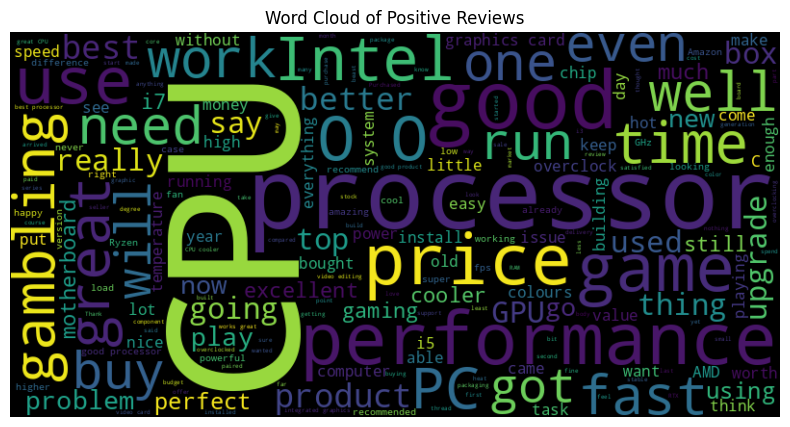

In [19]:
from wordcloud import WordCloud
# Filter positive reviews
df_positive = df[df.sentiment == 'positive']

# Combine all positive reviews into a single string
text_positive = ' '.join(df_positive['translated_content'])

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text_positive)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Positive Reviews')
plt.show()

4.Visualization of Important Words from Neutral Reviews

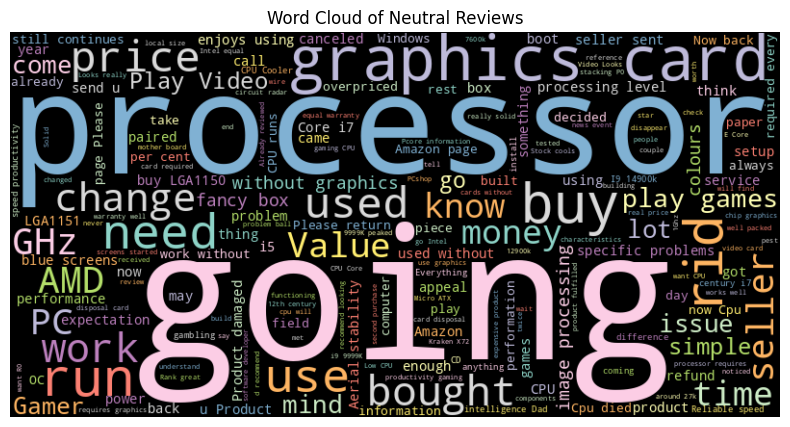

In [20]:
# Filter neutral reviews
df_neutral = df_upsampled[df_upsampled.sentiment == 'neutral']

# Combine all neutral reviews into a single string
text_neutral = ' '.join(df_neutral['translated_content'])

# Generate a word cloud with a black background
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Set3').generate(text_neutral)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Neutral Reviews')
plt.show()

5.Visualization of Important Words from Negative Reviews

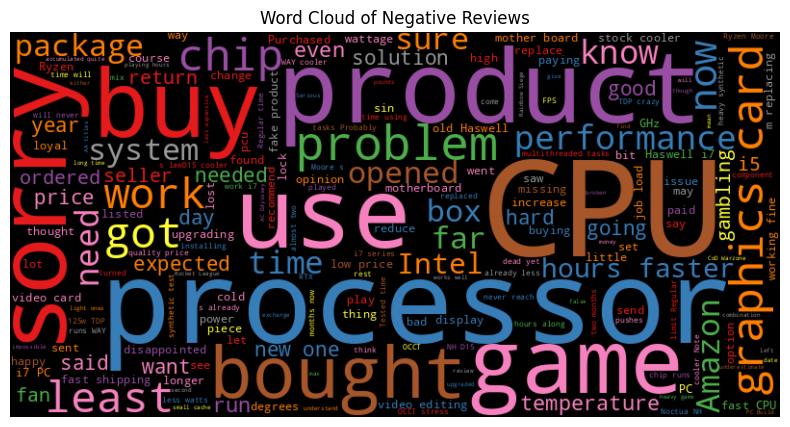

In [21]:
# Filter negative reviews
df_negative = df_upsampled[df_upsampled.sentiment == 'negative']

# Combine all negative reviews into a single string
text_negative = ' '.join(df_negative['translated_content'])

# Generate a word cloud with a black background
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Set1').generate(text_negative)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Negative Reviews')
plt.show()

6:Bigram Analysis: Using CountVectorizer to find and visualize the most common bigrams (pairs of words).

<ipython-input-22-c7b09ca5ff03>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Bigram', data=common_bigrams, palette='magma')


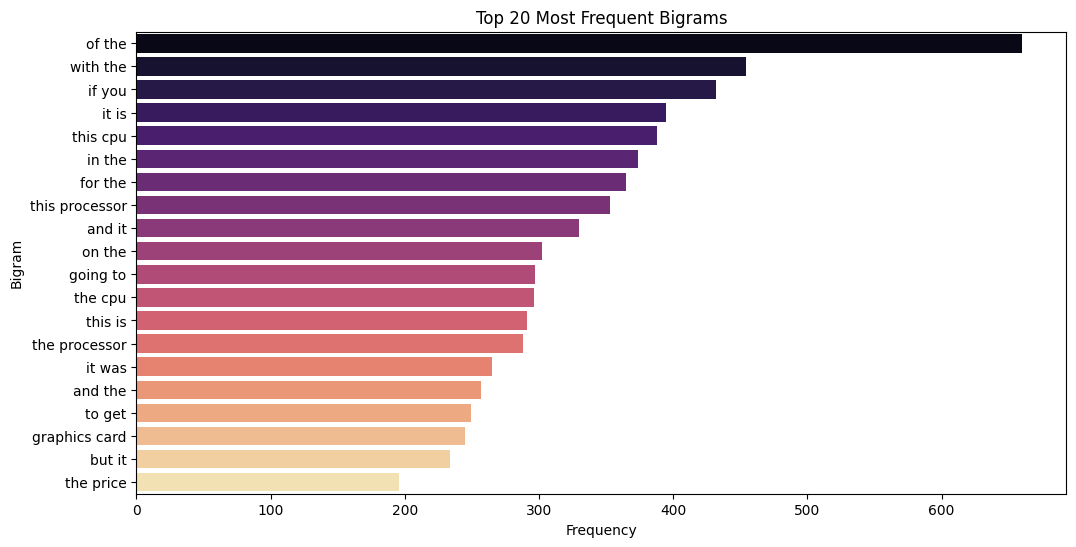

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

# Function to get the most frequent bigrams
def get_most_frequent_bigrams(text_series, num_bigrams=20):
    vectorizer = CountVectorizer(ngram_range=(2, 2))
    X = vectorizer.fit_transform(text_series)
    bigram_freq = X.sum(axis=0).A1
    bigrams = vectorizer.get_feature_names_out()
    bigram_freq_df = pd.DataFrame(list(zip(bigrams, bigram_freq)), columns=['Bigram', 'Frequency'])
    bigram_freq_df = bigram_freq_df.sort_values(by='Frequency', ascending=False).head(num_bigrams)
    return bigram_freq_df

# Get the most frequent bigrams for the entire DataFrame
common_bigrams = get_most_frequent_bigrams(df['translated_content'])

# Plot the most frequent bigrams
plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Bigram', data=common_bigrams, palette='magma')
plt.title('Top 20 Most Frequent Bigrams')
plt.xlabel('Frequency')
plt.ylabel('Bigram')
plt.show()

#Data Preparation

Separating the data and Label

In [23]:
x=df_upsampled['stemmed_reviews'].values
y=df_upsampled['sentiment'].values

In [24]:
print(x)

['good gambl excel perform valu money good stream'
 'gamer long shot want power intel base cpu maxim matterboard along ass rtx gpu realli case mani other instal high qualiti mm'
 'consid current price give rang game game sloter x would say best choic gambl x match even compar pbo x mean compar cpu game game good use'
 ...
 'sinc instal pcu sturgl system stabil paint wrong yet may fals cpu could anoth devic caus issu watchdog code error updat problem graphic card reason need move differ slot system stabl also configur cool fan provid better air flow cpu run hot clock although clock benchmark test still rate pcu high'
 'got processor broken secur seal far everyth work right like way'
 'temperatur cpu cool xilenc xc also degre min output cpu c cpu ker thread run gz base stick gz turbot']


In [25]:
print(y)

['positive' 'positive' 'positive' ... 'negative' 'negative' 'negative']


Splitting the data into training data and test data

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=4)
print(x.shape, x_train.shape, x_test.shape)
print(y.shape, y_train.shape, y_test.shape)

(7701,) (6160,) (1541,)
(7701,) (6160,) (1541,)


Converting the textual data into numerical data using vectoriser

In [27]:
vectorizer=TfidfVectorizer()
x_train=vectorizer.fit_transform(x_train)
x_test=vectorizer.transform(x_test)

In [28]:
print(x_train)

  (0, 2832)	0.22105644360486268
  (0, 1919)	0.22105644360486268
  (0, 1952)	0.18348499329886445
  (0, 2346)	0.14071675389391336
  (0, 1322)	0.11100674510656929
  (0, 652)	0.13334557511170983
  (0, 2105)	0.12099141348242565
  (0, 263)	0.12240543602484066
  (0, 2067)	0.17376146126317774
  (0, 432)	0.15961599788588185
  (0, 1123)	0.08916396332054798
  (0, 25)	0.16121793548633434
  (0, 1414)	0.20796773436685168
  (0, 1470)	0.0909636857487628
  (0, 1746)	0.15468691905489929
  (0, 1531)	0.11207698840436968
  (0, 2722)	0.1959249930520083
  (0, 1670)	0.1456120965040797
  (0, 2870)	0.22105644360486268
  (0, 117)	0.16382587845024185
  (0, 2401)	0.14846199269182014
  (0, 2846)	0.0683196543237093
  (0, 1206)	0.09700284372476711
  (0, 1506)	0.11869039917618372
  (0, 2092)	0.12632491692599912
  :	:
  (6156, 492)	0.21518170973736467
  (6156, 297)	0.1692747473122646
  (6156, 1918)	0.1352819349250426
  (6156, 2473)	0.21792023393885976
  (6156, 1961)	0.14496787365790426
  (6156, 497)	0.3491380050150851


In [29]:
print(x_test)

  (0, 2986)	0.08013810497536993
  (0, 2921)	0.17532587643544476
  (0, 2316)	0.19628480282795358
  (0, 2295)	0.12379641988491025
  (0, 2003)	0.21507400449447098
  (0, 1918)	0.08832290726449955
  (0, 1804)	0.09902083320298265
  (0, 1721)	0.22397410429424924
  (0, 1566)	0.1336434695527002
  (0, 1503)	0.12056906732781009
  (0, 1485)	0.24253909571451948
  (0, 1466)	0.14107086504453006
  (0, 1322)	0.11743784932377713
  (0, 1304)	0.2260649828878711
  (0, 1296)	0.17236580161134513
  (0, 1230)	0.11646963611311435
  (0, 1188)	0.12949691605222804
  (0, 1186)	0.1336434695527002
  (0, 1087)	0.18519975152060672
  (0, 970)	0.16503901783954922
  (0, 925)	0.4521299657757422
  (0, 917)	0.14107086504453006
  (0, 876)	0.11935208593729109
  (0, 652)	0.2821417300890601
  (0, 609)	0.1672682532108842
  :	:
  (1537, 15)	0.7847315230014629
  (1538, 2986)	0.24233068794400786
  (1538, 2979)	0.3138480900749453
  (1538, 2028)	0.22128216718325663
  (1538, 1123)	0.28524460028944437
  (1538, 915)	0.45136388423512736
 

#Training and Evaluation of the Machine Learning Model

Logistic Regression Model

In [30]:
model=LogisticRegression(max_iter=1000)
model.fit(x_train,y_train)

LogisticRegression(max_iter=1000)

Model Evaluation

Accuracy score on the training data

In [31]:
x_train_prediction=model.predict(x_train)
training_data_accuracy=accuracy_score(y_train,x_train_prediction)
print('Accuracy score on training data :' , training_data_accuracy)

Accuracy score on training data : 0.9849025974025974


Accuracy score on the test data

In [32]:
x_test_prediction=model.predict(x_test)
test_data_accuracy=accuracy_score(y_test,x_test_prediction)
print('Accuracy score on test data :' , test_data_accuracy)

Accuracy score on test data : 0.9746917585983128


Model Accuracy = 97.46%

Saving the model for future predictions

In [33]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

Using the saved model for new predictions

In [34]:
load_model=pickle.load(open('/content/finalized_model.sav','rb'))

In [35]:
#Taking a random data point for prediction
x_random=x_test[250]
print(y_test[250])

negative


In [36]:
#Using the model to predict the same y value
prediction=load_model.predict(x_random)
print(prediction)

['negative']


It is predicting correctly